# Handwritten digit classification via transfer learning

... to decode the MNIST 784 dataset. This dataset contains a subset of 70,000 size-normalized and centered hand written digits. Previously a convolutional neural network was built with 99.6% accuracy.

...

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint

In [2]:
#fully connected training iterations
fc_iter = 1

#fine tuning traiing iterations
ft_iter = 1

### Preprocessing data

In [3]:
#Loading MNIST_784 dataset from OpenML
mnist = fetch_openml('mnist_784', as_frame = False, parser='auto') 
X,y = mnist.data.reshape(-1,28,28,1)/255, mnist.target.reshape(-1,1)
y = y.astype(np.int64)

In [4]:
#Defining function to look at a digit
def show_num(input_pic):
  plt.imshow(input_pic,cmap='binary')
  plt.axis(False)

Image shape before:
(70000, 28, 28, 1)
Image shape after:
(70000, 28, 28, 3)

Checking Image:


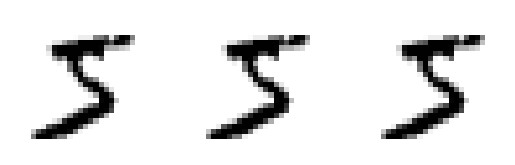

In [5]:
#repeating gray scale image in 3 channel format for compatability with three channel format 
#of the pre-trained network

print('Image shape before:')
print(X.shape)  
X_rgb = np.repeat(X,3,axis=-1)
print('Image shape after:')
print(X_rgb.shape)

print('\nChecking Image:')
#checking repeat image 
for n in range(3):
    ax = plt.subplot(1,3,n+1)
    show_num(X_rgb[0][:,:,n])

### Fully connected layer definition

In [ ]:
class fully_connected_layers(tf.keras.layers.Layer):
    def __init__(self,n=32,**kwargs):
        super().__init__(**kwargs)

        self.flatten = tf.keras.layers.Flatten()
        self.hidden1 = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')
        self.hidden2 = tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')
        self.hidden3 = tf.keras.layers.Dense(units=10, activation='linear', kernel_initializer='he_normal')
        self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self,inputs,trainable = False):
        if trainable == False: 
            self.resnet.trainable = False
        if trainable == True: 
            self.resnet.trainable == True #unfreezes base model
            for layer in self.resnet: #freezes batch normalization layers
                if (isinstance(layer, tf.keras.layers.BatchNormalization)):
                    layer.trainable = False
                    
        X = self.flatten(X)
        X = self.hidden1(X)
        X = self.dropout(X)
        X = self.hidden2(X)
        X = self.dropout(X)
        return self.hidden3(X)
    
fully_connected_layers = fully_connected_layers()

In [ ]:
inputs_resnet = tf.keras.Input(shape=(28,28,3), name='Input')
x_resnet = tf.keras.layers.Resizing(32,32)(inputs_resnet)
print(x_resnet)
x_resnet = ResNet50(x_resnet)
outputs_resnet = fully_connected_layers(x_resnet)

model_resnet = tf.keras.Model(inputs_resnet, outputs_resnet)

test_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(0.001),
               metrics = ['accuracy'])

In [ ]:
test_model.fit(X_train[:5000], y_train[:5000], epochs=ft_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights])

In [ ]:
top_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')
],name='Fully_Connected_Layers')

### ResNet50

In [ ]:
#load Resnet 50
Resnet_50 = ResNet50(include_top=False, input_shape=(32,32,3),weights='imagenet')
Resnet_50.trainable = False #freezes model 
Resnet_50.summary()

In [ ]:
#create a new model on top 
inputs = tf.keras.Input(shape=(28,28,3), name='Input')
x = tf.keras.layers.Resizing(32,32)(inputs)
x = Resnet_50(x)
outputs = top_model(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(0.001),
               metrics = ['accuracy'])

In [ ]:
save_weights = ModelCheckpoint('weights_Resnet50_t.h5', save_best_only=True, save_weights_only=True)

In [ ]:
#just training the top layers
#model.load_weights('weights_Resnet50_t.h5')

history_resnet = model.fit(X_train, y_train, epochs=fc_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights])
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

model.save_weights('weights_Resnet50_t.h5')

#fine tuning the whole model 

model.load_weights('weights_Resnet50_t.h5')

Resnet_50.trainable = True #unfreezes base model
 
for layer in Resnet_50.layers: #freezes batch normalization layers
    if ('bn' in layer.name):
        layer.trainable = False
        
#check that BN layers are set to training = False
#for layer in Resnet_50.layers:
#    if layer.trainable:
#        print (layer.name)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(1e-6),
               metrics = ['accuracy'])

In [ ]:
history_resnet = model.fit(X_train[:5000], y_train[:5000], epochs=ft_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights])
acc += history_resnet.history['accuracy']
val_acc += history_resnet.history['val_accuracy']
loss += history_resnet.history['loss']
val_loss += history_resnet.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([fc_iter-1,fc_iter-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([fc_iter-1,fc_iter-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)
resnet_score = accuracy_score(y_test,y_pred)

### Inception V3

In [ ]:
#load Inception V3
inception_V3 = InceptionV3(include_top=False, input_shape=(75,75,3),weights='imagenet')
inception_V3.trainable = False #freezes model 
inception_V3.summary()

In [ ]:
top_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')
],name='Fully_Connected_Layers')

In [ ]:
#add fully connected layers
inputs_inception = tf.keras.Input(shape=(28,28,3), name='Input')
xx = tf.keras.layers.Resizing(75,75)(inputs_inception)
xx = inception_V3(xx)
outputs_inception = top_model(xx)

model_inception = tf.keras.Model(inputs_inception, outputs_inception)
model_inception.summary()

In [ ]:
save_weights_inception = ModelCheckpoint('weights_inceptionV3_t.h5', save_best_only=True, save_weights_only=True)

In [ ]:
model_inception.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(0.001),
               metrics = ['accuracy'])

In [ ]:
#just training the top layers
#model_inception.load_weights('weights_inceptionV3_t.h5')
model_inception.fit(X_train, y_train, epochs=fc_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights_inception])
model_inception.save_weights('weights_inceptionV3_t.h5')

In [ ]:
#fine tuning the whole model 
#model_inception.load_weights('weights_inceptionV3_t.h5')
inception_V3.trainable = True #unfreezes base model

for layer in inception_V3.layers: #freezes batch normalization layers
    if (isinstance(layer, tf.keras.layers.BatchNormalization)):
        layer.trainable = False
        
#check that BN layers are set to training = False
#for layer in inception_V3.layers:
    #if layer.trainable == False:
        #print (layer.name)
        

model_inception.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(1e-5),
               metrics = ['accuracy'])

In [ ]:
model_inception.fit(X_train, y_train, epochs=ft_iter, validation_data=(X_valid, y_valid), callbacks=[save_weights_inception])

In [ ]:
y_pred = model_inception.predict(X_test).argmax(axis=1)
inception_score = accuracy_score(y_test,y_pred)
inception_score

### Mobile Net

In [ ]:
#load mobile net
mobile_net = MobileNet(include_top=False, input_shape=(32,32,3),weights='imagenet')
mobile_net.trainable = False #freezes model 
mobile_net.summary()

In [ ]:
top_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')
],name='Fully_Connected_Layers')

In [ ]:
#add fully connected layers
inputs_mobile = tf.keras.Input(shape=(28,28,3), name='Input')
xxx = tf.keras.layers.Resizing(32,32)(inputs_mobile)
xxx = mobile_net(xxx)
outputs_mobile = top_model(xxx)

model_mobile = tf.keras.Model(inputs_mobile, outputs_mobile)
model_mobile.summary()

In [ ]:
save_weights_mobile = ModelCheckpoint('weights_mobilenet_t', save_best_only=True, save_weights_only=True)

In [ ]:
model_mobile.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(0.001),
               metrics = ['accuracy'])

In [ ]:
#just training the top layers
#model.load_weights('weights_mobilenet_t.h5')
model_mobile.fit(X_train, y_train, epochs=fc_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights_mobile])
model_mobile.save_weights('weights_mobilenet_t.h5')

In [ ]:
#fine tuning the whole model 
#model_mobile.load_weights('weights_mobilenet_t.h5')
mobile_net.trainable = True #unfreezes base model

for layer in mobile_net.layers: #freezes batch normalization layers
    if isinstance(layer,tf.keras.layers.BatchNormalization):
        layer.trainable = False
        
model_mobile.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(1e-5),
               metrics = ['accuracy'])

In [ ]:
model_mobile.fit(X_train, y_train, epochs=ft_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights_mobile])

In [ ]:
y_pred = model_mobile.predict(X_test).argmax(axis=1)
mobile_score = accuracy_score(y_test,y_pred)
mobile_score